57 вариант

E U N W K T M L R I

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import math
from collections import Counter
%matplotlib inline

 - 1

In [59]:
from BranchingProcess import Person, BranchingProcess, read_from_files
file_pref = ['E','U','N','W','K','T','M','L','R','I']
file_names = [pref + '.txt' for pref in file_pref]

In [60]:
processes = read_from_files(file_names)

In [96]:
print(len(processes))

74142


In [86]:
# delete dummy nodes (with unknown gender and has no children(leaf in generation-tree))
def clear_data(processes) :
    processes_new = []
    for proc in processes :
        new_proc = BranchingProcess()
        children = set()
        proc.generations.reverse()

        for generation in proc.generations:
            new_generation = []
            for person in generation :
                
                if person.gender == 'male' or person.gender == 'female':
                    children.add(person.name)
                    new_generation.append(person)    
                else :     
                    is_leaf = True
                    for ch in person.children:
                        if ch in children :
                            is_leaf = False
                            break
                    if not is_leaf :
                        new_generation.append(person)    

            if len(new_generation) > 0 :
                new_generation.reverse()
                new_proc.generations.append(new_generation)

        if len(new_proc.generations) > 1 :
            processes_new.append(new_proc)
    return processes_new


In [97]:
processes = clear_data(processes)

In [98]:
print(len(processes))

21242


In [99]:
# check that all deleted items were leafs
for proc in processes :
    for generation in proc.generations:
        for person in generation :
            if person.gender != 'male' and person.gender != 'female':
                print("Empty NO-leaf")

- 2

In [180]:
lenghts = [len(proc.generations) for proc in processes]
min_family_length = np.min(lenghts)
max_family_length = np.max(lenghts)
avg_family_length = np.mean(lenghts)
print('min family length = ' + str(min_family_length))
print('max family length = ' + str(max_family_length))
print('avg family length = ' + str(round(avg_family_length,2)))

min family length = 2
max family length = 81
avg family length = 3.25


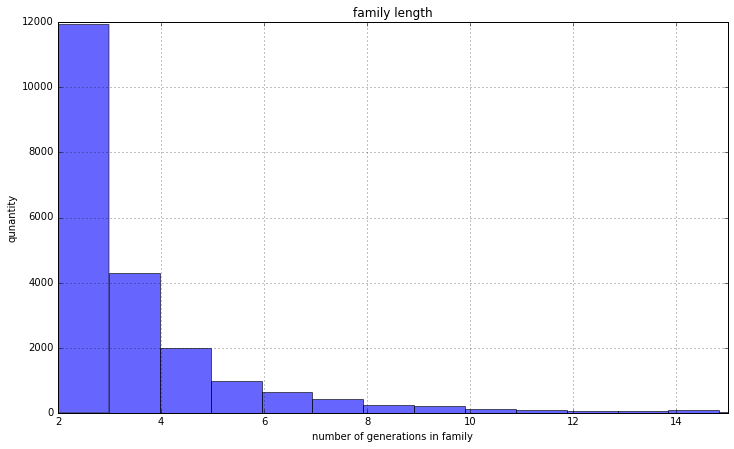

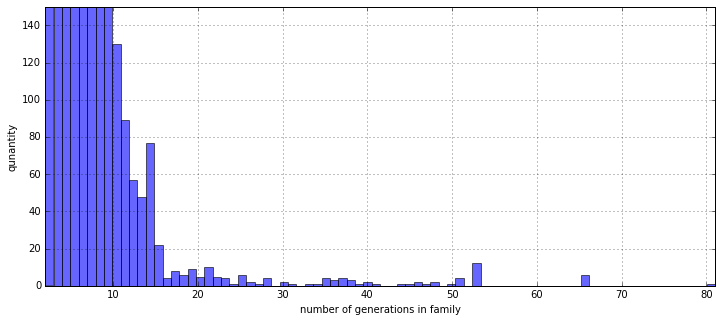

In [273]:
plt.figure(figsize=(12,7))
plt.title("family length")

plt.hist(lenghts, 80, facecolor='b', alpha=0.6)
plt.grid(True)
plt.xlim(2,15)
plt.xlabel("number of generations in family")
plt.ylabel("qunantity")
plt.show()


plt.figure(figsize=(12,5))
plt.grid(True)
plt.ylim(0,150)
plt.xlim(2,81)
plt.xlabel("number of generations in family")
plt.ylabel("qunantity")
plt.hist(lenghts, 80, facecolor='b', alpha=0.6)
plt.show()


In [191]:
# this function returns year(int) from date-info string
def get_year(s) : 
    if len(s) == 0:
        return -5000
    x = s.split('-')
    if(x[0] == '') :
        return -5000
    return int(x[0])


birth_years = []
life_time = []
for proc in processes :
    for generation in proc.generations :
        for p in generation : 
            byear = get_year(p.birthday)
            dyear = get_year(p.deathdate)
            if byear > -5000:
                birth_years.append(byear)
                if dyear > -5000 :
                    life_time.append(dyear - byear)
            
min_birthyear , max_birthyear = np.min(birth_years) , np.max(birth_years)
avg_life_time = np.mean(life_time)
print('min value of birthyear = ' + str(min_birthyear))
print('max value of birthyear = ' + str(max_birthyear))
print('avg value of life time = ' + str(round(avg_life_time,1)))

min value of birthyear = 1
max value of birthyear = 2007
avg value of life time = 57.7


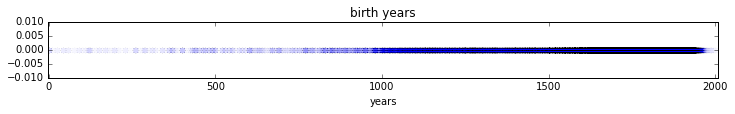

In [214]:
plt.figure(figsize=(12,1))
plt.ylim(-0.01,0.01)
plt.xlim(-1,2008)
plt.xlabel("years")
plt.title("birth years")
plt.plot([x for x in birth_years],[0 for i in range(len(birth_years))],'o',alpha = 0.002)
plt.show()

- 3

In [272]:
def pois_likelyhood_estimation(X) :
    return np.mean(X)    